**Simple supported beam adaptive method**

cloning from github essentials files

In [1]:
 ! git  clone --recursive  https://github.com/cmi-kamalos/PINN_Structural_health_monotoring

Cloning into 'PINN_Structural_health_monotoring'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 138 (delta 19), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (138/138), 997.34 KiB | 13.66 MiB/s, done.
Resolving deltas: 100% (49/49), done.


switching to tensordiff folders (forked works from tensordiffeq)

In [2]:
cd /content/PINN_Structural_health_monotoring/from_tensordiff

/content/PINN_Structural_health_monotoring/from_tensordiff


In [3]:
pip install pyDOE2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=d50653d560bf16bdf77feb04a3956eb078d5c98dac63b0156c16db059361c848
  Stored in directory: /root/.cache/pip/wheels/49/91/2d/d08e80806bf7756193541f6c03c0492af288fcd6158d3d0998
Successfully built pyDOE2


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install pyfiglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 865 kB 8.1 MB/s 


In [7]:
import math
import os
import numpy as np
import sys
import inspect
import tensorflow as tf
import os


In [8]:
# !cp /content/drive/MyDrive/tensordiff/models.py  /content
# !cp /content/drive/MyDrive/tensordiff/boundaries.py  /content
# !cp /content/drive/MyDrive/tensordiff/domains.py  /content
# !cp /content/drive/MyDrive/tensordiff/helpers.py  /content
# !cp /content/drive/MyDrive/tensordiff/networks.py  /content
# !cp /content/drive/MyDrive/tensordiff/optimizers.py  /content
# !cp /content/drive/MyDrive/tensordiff/output.py  /content
# !cp /content/drive/MyDrive/tensordiff/sampling.py  /content
# !cp /content/drive/MyDrive/tensordiff/utils.py  /content
# !cp /content/drive/MyDrive/tensordiff/fit.py  /content
# !cp /content/drive/MyDrive/tensordiff/plotting.py  /content
# !cp /content/drive/MyDrive/tensordiff/__init__.py  /content

In [9]:
import utils
import domains
import models 
import plotting
import boundaries
import helpers
import networks
import output
import sampling
import fit
import __init__


tensordiff *essentials* **package**

In [10]:
from  boundaries import *
from  domains import DomainND
from utils import constant
from models import CollocationSolverND
from tensorflow import sin, cos


Domains

In [11]:
Domain =DomainND(["x", "t"], time_var='t')

Domain.add("x", [0.0, 1.0], 150)
Domain.add("t", [0.0, 1.0], 150)

Generate **Collocations** points

In [12]:
N_f = 22500
Domain.generate_collocation_points(N_f)

Initial condition (***IC***) functions

In [13]:
def func_ic_1(x):
    return sin(math.pi*x)


def func_ic_2(x):
    return cos(math.pi*x)

*exact* solution function

In [14]:

def f_real(x,t):
      return np.sin( math.pi*x) * np.cos((math.pi **2) * t)

function input for neumann boundary

In [15]:
def func_input(x):
    return sin( constant(math.pi)*x)*cos((constant(math.pi) **2)*x)

functions for dirichletfunction boundary

In [16]:
def func_upper_x(x):
    return sin(constant(math.pi) * x)
def func_upper_y(t):
    return cos(constant(math.pi**2)*t)

**Initial Conditions**

In [17]:
init1 = IC(Domain, [func_ic_1], var=[['x']])
init2 = IC(Domain, [func_ic_2], var=[['x']])


derivative **boundary** function

In [18]:
def func_boundary(u_model,x,t):
    u = u_model(tf.concat([x, t], 1))
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    return u,u_xx

**Dirichlet and neumann boundary**

In [19]:
bnd_x_0 = dirichletBC(Domain, val=0.0, var='x', target="lower")
bnd_x_l = dirichletBC(Domain, val=0.0, var='x', target="upper")
# bnd_xx_0 = FunctionDirichletBC(Domain, fun=[func_input], var='x', target="upper", func_inputs=["x"], n_values=30)
# bnd_xx_l = FunctionDirichletBC(Domain, fun=[func_input], var='x', target="lower", func_inputs=["t"], n_values=30)

bnd_xx_0=FunctionNeumannBC(Domain,[func_input],var=['x'],target='lower',deriv_model=[func_boundary],func_inputs=['x'],n_values=150)
bnd_xx_l=FunctionNeumannBC(Domain,[func_input],var=['x'],target='upper',deriv_model=[func_boundary],func_inputs=['x',],n_values=150)



*Boundary conditions*

In [20]:
BCs = [init1,init2,bnd_x_0,bnd_x_l,bnd_xx_0,bnd_xx_l]

**Model**

In [21]:
def f_model(u_model, x, t):
    u = u_model(tf.concat([x, t], 1))
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_xxx=tf.gradients(u_x, x)[0]
    u_x4=tf.gradients(u_xxx,x)[0]
    u_t = tf.gradients(u,t)[0]
    u_tt=tf.gradients(u_t,t)[0]
    a1 = constant(1.0)
    a2 = constant(1.0)
    pi = constant(math.pi)

    # we use this specific forcing term because we have an exact analytical solution for this case
    # to compare the results of the PINN solution
    # note that we must use tensorflow math primitives such as sin, cos, etc!
    forcing = -sin(pi * x) * cos((pi **2)* t)
    f_u=u_x4+u_tt-forcing
    return f_u

loss functions with have adaptive weights

In [22]:
dict_adaptive = {"residual": [True,True,True],
                 "BCs": [False, False,True,True,True,True]}

dictionary with keys "residual" and "BCs"

In [23]:
init_weights = {"residual": [tf.random.uniform([N_f, 1]),tf.random.uniform([150, 1]),tf.random.uniform([150, 1])],
                "BCs": [None,None,tf.random.uniform([150, 1]), tf.random.uniform([150, 1]), tf.random.uniform([150, 1]),tf.random.uniform([150, 1])]}

g a lambda function

In [24]:
def g(lam):
    return lam**2

Structure of w (layers)

In [25]:
layer_sizes = [2,100,100,100,1]

*collocation solver*

In [26]:
model = CollocationSolverND()



In [27]:
model.compile(layer_sizes, f_model, Domain, BCs)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Reproduce results from ***Raissi*** and the ***SA-PINNs*** paper, train for 10k newton and 10k adam

In [28]:
model.fit(tf_iter=10000, newton_iter=10000)

    ____  _           
   / __ \(_)___  ____ 
  / /_/ / / __ \/ __ \
 / ____/ / / / / / / /
/_/   /_/_/ /_/_/ /_/ 
                      

Neural Network Model Summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________
None
Starting Adam training


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting L-BFGS training
Executing eager-mode L-BFGS


  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
model.save("model_beam")

In [30]:
nx, nt = (150, 150)

setup conditions

In [31]:
x_ = np.linspace(0, 1, nx)
t_ = np.linspace(0, 1, nt)

xv, yv = np.meshgrid(tf.squeeze(x_), tf.squeeze(t_))



x = np.reshape(x_, (-1, 1))
t = np.reshape(t_, (-1, 1))

Exacte solution

In [32]:
z=f_real(xv,yv)

Exact_u=z


Flatten for use

In [33]:
u_star = Exact_u.flatten()[:, None]

create a mesh

In [34]:
x = Domain.domaindict[0]['xlinspace']
t = Domain.domaindict[1]["tlinspace"]

X, T = np.meshgrid(x, t)

In [35]:
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

predict

In [36]:
u_pred, f_u_pred = model.predict(X_star)

Error margins

In [37]:
error_u = helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))

Error u: 9.555507e-01


Plotting prediction, exact solution and residual

Exact_u (150, 150) domain (150,) (150, 150)


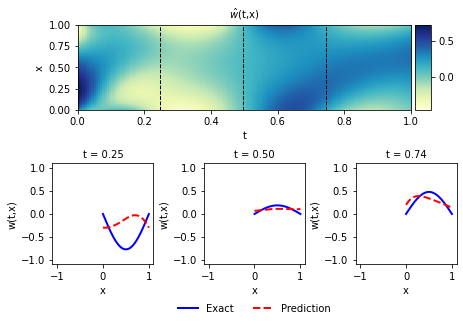

In [38]:
U_pred = plotting.get_griddata(X_star, u_pred.flatten(), (X, T))
FU_pred = plotting.get_griddata(X_star, f_u_pred.flatten(), (X, T))

lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])
plotting.plot_solution_domain1D(model, [x, t], ub=ub, lb=lb, Exact_u=Exact_u)


(150, 150) (150, 150) (150, 150)
150


/content/PINN_Structural_health_monotoring/from_tensordiff/plotting.py:189: UserWarning: The following kwargs were not used by contour: 'aspect'
  origin='lower', aspect='auto')


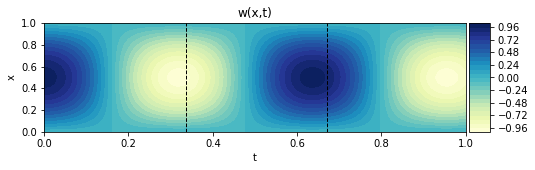

In [39]:
plotting.plot3D(x,t,z,ub, lb)

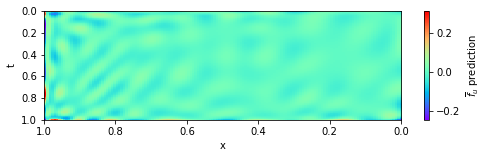

In [40]:
plotting.plot_residuals(FU_pred,lb,ub)